In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import copy
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Hao_PBMC_GSE164378_raw.h5ad")
adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Hao_PBMC_GSE164378_raw.h5ad')
adata.shape

(161764, 33538)

## Normalization

In [3]:
# Normalization
# each observation (cell) has a total count equal to the median of total counts for observations (cells)
sc.pp.normalize_total(adata, target_sum=None)  # see PreLect performance to see if target_sum is needed
# log1p transformation
sc.pp.log1p(adata)

In [4]:
type(adata.X)

scipy.sparse.csc.csc_matrix

## UMAP Jaccard (before batch effect correction)

In [5]:
sc.tl.pca(adata, svd_solver="arpack")

In [7]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, metric='jaccard', key_added='jaccard')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [8]:
adata.obsp

PairwiseArrays with keys: jaccard_distances, jaccard_connectivities

In [16]:
adata.uns

OrderedDict([('log1p', {'base': None}),
             ('pca',
              {'params': {'zero_center': True,
                'use_highly_variable': False,
                'mask_var': None},
               'variance': array([118.92531667,  34.68126828,  14.4715077 ,  13.67616668,
                       10.27245337,   7.58818843,   6.09966162,   5.03523017,
                        4.13648053,   2.97410969,   2.80477438,   2.35231075,
                        1.967979  ,   1.7672519 ,   1.64241784,   1.50401774,
                        1.46081942,   1.34500386,   1.16306698,   1.10329985,
                        1.03489837,   1.01514668,   0.99940818,   0.91187745,
                        0.89680901,   0.88319322,   0.81016267,   0.79891642,
                        0.7584643 ,   0.72880425,   0.72652203,   0.70135399,
                        0.68435468,   0.66364484,   0.6272985 ,   0.62214793,
                        0.596573  ,   0.5759497 ,   0.57153632,   0.56403504,
                   

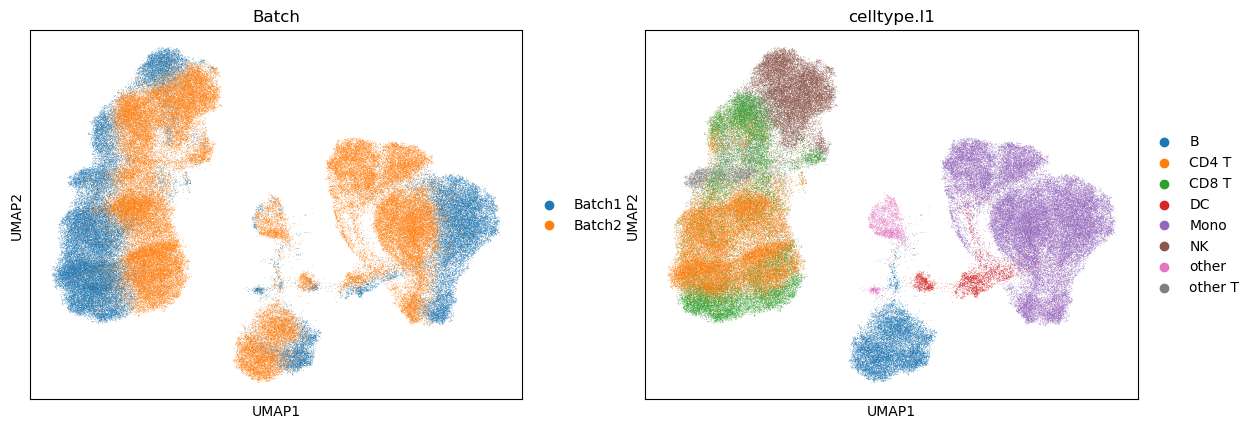

In [10]:
sc.tl.umap(adata, neighbors_key='jaccard')
sc.pl.umap(adata, color=['Batch', 'celltype.l1'])

## Batch effect correction with Harmony

In [11]:
import scanpy.external as sce

# sce.pp.harmony_integrate(adata, key='Batch')
sce.pp.harmony_integrate(adata, key=['Batch', 'donor'])

# Harmony works by adjusting the principal components
# this function should be run after performing PCA but before computing the neighbor graph


2024-05-06 15:31:28,732 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-06 15:31:52,009 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-06 15:31:52,647 - harmonypy - INFO - Iteration 1 of 10
2024-05-06 15:32:50,850 - harmonypy - INFO - Iteration 2 of 10
2024-05-06 15:33:50,519 - harmonypy - INFO - Iteration 3 of 10
2024-05-06 15:34:44,200 - harmonypy - INFO - Converged after 3 iterations


In [12]:
# Harmony adds a new table in adata.obsm containing the adjusted PC’s.
'X_pca_harmony' in adata.obsm

True

In [13]:
# After Harmony, compute neighbors with Jaccard metric
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca_harmony', metric='jaccard', key_added='jaccard')

/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


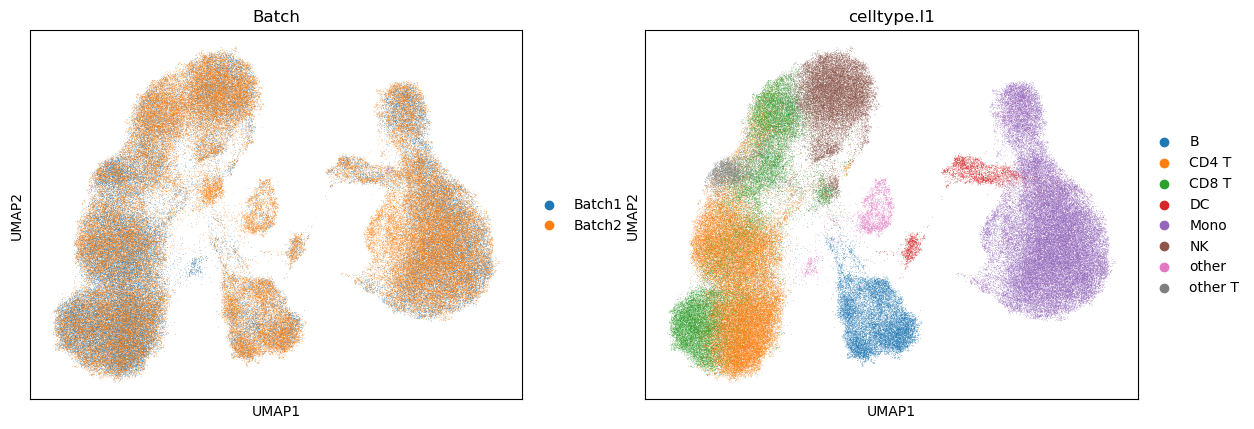

In [14]:
sc.tl.umap(adata, neighbors_key='jaccard')
sc.pl.umap(adata, color=['Batch', 'celltype.l1'])

## Leiden

In [17]:
sc.tl.leiden(adata, resolution=0.9, neighbors_key='jaccard')

In [20]:
sc.tl.paga(adata, neighbors_key='jaccard')
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga', neighbors_key='jaccard')


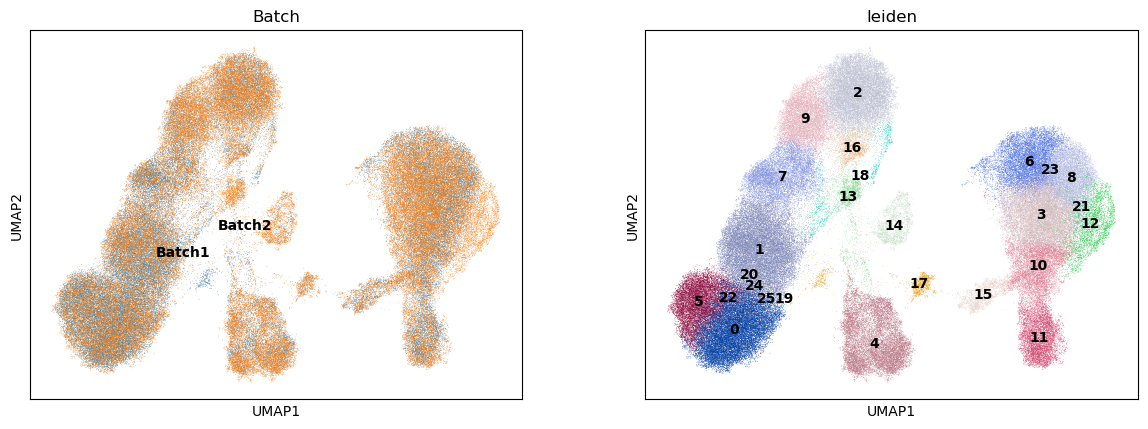

In [24]:
sc.pl.umap(adata, color=['Batch', 'leiden'], legend_loc="on data")

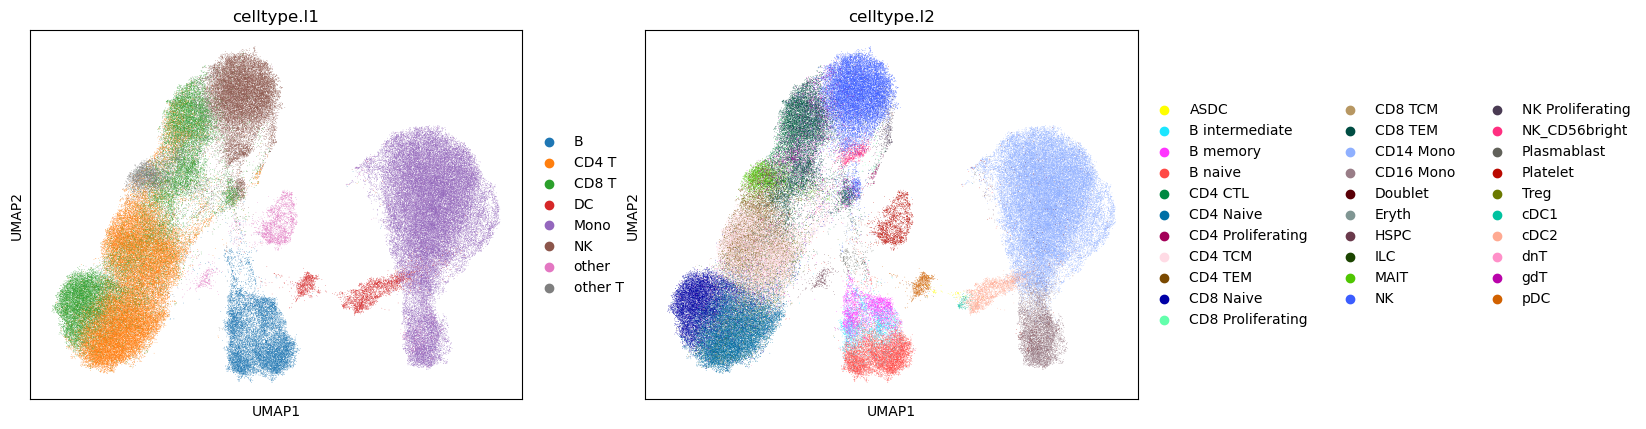

In [23]:
sc.pl.umap(adata, color=['celltype.l1', 'celltype.l2'])